## Motivation: Where Do Sequential Models Fall Short?

### Disadvantages of Sequential Models

- As the sequence length of documents increases, memory and computational power become bottlenecks, since we are unable to parallelize the computation across each sequence step. 
- Usually, the information carried over from earlier tokens (positional indices further away) is greatly diminished, even with the adaptations made with LSTMs.

## Overview of Transformer Architecture

The original *Attention Is All You Need* paper is [available here](https://arxiv.org/pdf/1706.03762.pdf).

The overall architecture of the **Transformer** model is defined here from the paper:
![transformers](https://raw.githubusercontent.com/ychennay/dso-560-nlp-text-analytics/main/images/transformers.png)

## Interpreting Attention

When our model assigns a higher attention score to a specific token of a document (ie., to specific index positions of the sequence), then the calculation for the decoder’s output will more strongly weighted by the input embeddings' contributions of this specific token.

## Understanding Positional Encodings

### How Position Is Encoded In Sequential Models

In RNNs and other sequential models, we are essentially constructing a neural network with as many layers as sequence steps. For instance, when an RNN processes a sequence of 4 documents, it is essentially computing the output of a
4-layer hidden neural network. This is why we call RNNs "unrolled" feed-forward
neural networks.

There is no explicit encoding for position in an RNN (ie., there is nothing that we directly pass into model itself as input that represents the "position"
of the token.

### How Position Is Encoded In Attention-Based Models

Since we are computing all sequence steps at the same time in an attention-based
model, we do not pass inputs into the model sequentially. **All time steps are
processed at the same time.**

In [ ]:
import math
import numpy as np

def positional_encoding(position: int, num_dimensions: int) -> np.array:
    """
    Computes the positional encoding vector (of size num_dimensions) given
    a certain position index, using the definition from Vaswani et al. 2017
    (https://arxiv.org/abs/1706.03762).

    :param position: The index position to generate the encoding for.
    :param num_dimensions: The number of dimensions to generate the encoding for.
    :return: A numpy array with an embedded representation of a token's specific position.
    """
    encoding = np.zeros((1, num_dimensions))  # a 1 x D dimensional array
    for idx in range(0, num_dimensions, 2):
        value = position / 10_000 ** ((2 * idx) / num_dimensions)
        encoding[0][idx], encoding[0][idx + 1] = math.sin(value), math.cos(value)
    return encoding

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
print(f"Position 1: {positional_encoding(1, 10)}")
print(f"Position 2: {positional_encoding(2, 10)}")

Position 1: [[8.41470985e-01 5.40302306e-01 2.51162229e-02 9.99684538e-01
  6.30957303e-04 9.99999801e-01 1.58489319e-05 1.00000000e+00
  3.98107171e-07 1.00000000e+00]]
Position 2: [[ 9.09297427e-01 -4.16146837e-01  5.02165994e-02  9.98738351e-01
   1.26191435e-03  9.99999204e-01  3.16978638e-05  9.99999999e-01
   7.96214341e-07  1.00000000e+00]]


#### Visualize the Cosine Similarity of Positional Encodings
We'll generate positional encodings of dimension size 300 and then calculate their similarity. Notice that positions closer to each other have higher similarities than positions that are further away. 

In this way, we've created encodings that represent the relative distance a token is from another token - **without having to rely upon explicitly modelling sequence**.

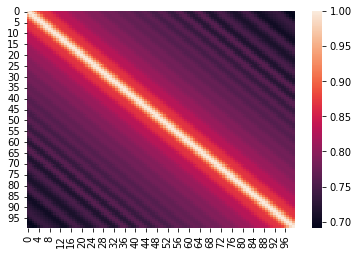

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

NUM_DIMENSIONS = 300
MAX_NUMBER_OF_POSITIONS = 100

sns.heatmap(cosine_similarity(np.array([positional_encoding(idx, NUM_DIMENSIONS) 
    for idx in range(MAX_NUMBER_OF_POSITIONS)]).reshape(MAX_NUMBER_OF_POSITIONS, NUM_DIMENSIONS)))

### Understanding Attention

Imagine that one of your tasks is to build a model that translates from English to Spanish, or vice versa. 

What would be the problem if you simply feed in the sentence "Are you still at home?" ([Tensorflow.org Neural Machine Translation with Attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention))

The Spanish translation is "¿Todavía estan en la casa?"

Notice however, that the word "still" maps to "todavía". However, "still" is the 3rd word of the English sequence, but the first word of the Spanish sequence.

If you use an feed-forward RNN, then you'll never be able to go back to make a prediction for the first element by the time that you've reached the 3rd element in the English sequence:
![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/800px-Recurrent_neural_network_unfold.svg.png)

In addition, remember that a key drawback of RNNs is that most of the information propagated forward is from the local sequence history - it's not great at carrying forward long-range dependencies.

Ideally, what we want is to give the model an idea of where in the sequence it should focus on to make a prediction for a particular sequence step:

![https://tensorflow.org/images/spanish-english.png](https://tensorflow.org/images/spanish-english.png)

As you can see, the shape of this attention matrix is $S \times S$, where $S$ is the sequence length. The value in the $i$th row and the $j$th column of this matrix represents how much the transformer should weight the input from the $j$th input sequence step when attempting to make a prediction for the $i$th output step.